 # Proyecto 3: Clustering
 ----
  
  University : UTEC \
  Course       : Machine Learning \
  Professor    : Cristian López Del Alamo 
  
 ----

Write the names and surnames of the members and the percentage of participation of each one in the development of the practice:
 - Integrante 1: Miguel Lama Carrasco(100%)
 - Integrante 2: Josue Arbulú Pastor(100%)
 - Integrante 3: Aaron SataMaria Gutierrez(100%)
 - Integrante 4: Lenin Chavez Zapata(100%)


 ----

## Importación de librerías

In [3]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_blobs
from sklearn.neighbors import KDTree
from sklearn.model_selection import train_test_split
from matplotlib.patches import Ellipse
from sklearn import random_projection
import umap
import matplotlib.pyplot as plt
from scipy.stats import mode

/opt/anaconda3/envs/MachineL/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset r2plus1d_34_8_ig65m_ft_kinetics

## Procesar los features extraídos

### Obtener un feature vector por cada video

In [7]:
def process_video_data(features_path, labels_data):
    # Inicializar listas para almacenar características, etiquetas y URLs
    features_list = []
    labels_list = []
    urls_list = []
    empty_frame_count = 0 # Contador de arreglos de características vacíos
    empty_frame_ids = [] # Lista para almacenar los IDs de videos con arreglos de características vacíos

    # Iterar sobre cada archivo .npy en el directorio dado (features_path)
    for video_file in glob.glob(os.path.join(features_path, "*.npy")):

        # Extraer el ID del video del nombre del archivo
        video_id = os.path.basename(video_file).split("_")[0]

        # Cargar el arreglo de características
        feature_array = np.load(video_file)

        # Verificar si el arreglo de características está vacío
        if feature_array.size == 0:
            empty_frame_count += 1 # Incrementar el contador de frames vacíos
            empty_frame_ids.append(video_id) # Almacenar el ID del video con el frame vacío
            continue # Saltar al siguiente archivo de video

        # Calcular el vector de características promedio para el video
        avg_feature = np.mean(feature_array, axis=0)
        features_list.append(avg_feature)

        # Obtener la etiqueta del video actual del DataFrame labels_data
        label = labels_data[labels_data["youtube_id"] == video_id]["label"].values[0]
        labels_list.append(label)

        # Obtener la URL de YouTube del video actual
        url = labels_data[labels_data["youtube_id"] == video_id]["youtube_id"].values[0]
        urls_list.append(url)

    print(f"Number of empty videos not included ({features_path}): {empty_frame_count}")
    print(f"Labels of empty videos not included: {empty_frame_ids}")

    # Apilar las características, etiquetas y URLs en arreglos numpy
    stacked_features = np.vstack(features_list)
    stacked_labels = np.vstack(labels_list)
    stacked_urls = np.vstack(urls_list)

    # Crear DataFrames a partir de los arreglos numpy apilados
    features_df = pd.DataFrame(stacked_features)
    labels_df = pd.DataFrame(stacked_labels)
    urls_df = pd.DataFrame(stacked_urls, columns=["youtube_id"])

    # Devolver los DataFrames que contienen URLs, características y etiquetas
    return urls_df, features_df, labels_df

In [8]:
# Leer los archivos CSV de etiquetas de entrenamiento, validación y prueba
df_train_labels = pd.read_csv(
    "./url_data/train_subset_10.csv", header=None, names=["youtube_id", "label"]
)
df_val_labels = pd.read_csv(
    "./url_data/val_subset_10.csv", header=None, names=["youtube_id", "label"]
)
df_test_labels = pd.read_csv(
    "./url_data/test_subset_10.csv", header=None, names=["youtube_id", "label"]
)

# Eliminar la primera fila de cada DataFrame (encabezado)
df_train_labels.drop(index=df_train_labels.index[0], axis=0, inplace=True)
df_val_labels.drop(index=df_val_labels.index[0], axis=0, inplace=True)
df_test_labels.drop(index=df_test_labels.index[0], axis=0, inplace=True)

# Mostrar las primeras filas del DataFrame de etiquetas de prueba
df_test_labels.head()

,youtube_id,label
1,oaVWnxlQOeo,NaN
2,7zMBk9Zu9fY,NaN
3,DwPEZeX5WkA,NaN
4,bO1MW9Lq9Sg,NaN
5,TdBpD9Ccg9w,NaN


In [9]:
models_r21d = ["r2plus1d_18_16_kinetics","r2plus1d_34_32_ig65m_ft_kinetics","r2plus1d_34_8_ig65m_ft_kinetics"]
# Iterar sobre cada modelo en la lista de modelos
for path in models_r21d:
    
    # Procesar datos de entrenamiento
    print("train")
    urls_train, X_train, Y_train = process_video_data(
    f"./Data Extracted/numpy_data/train/r21d/{path}/", df_train_labels)

    # Eliminar filas con valores NaN en los DataFrames de entrenamiento
    urls_train.dropna(inplace=True)
    X_train.dropna(inplace=True)
    Y_train.dropna(inplace=True)

    # Concatenar DataFrames de URLs, características y etiquetas de entrenamiento
    train_data_extracted_df = pd.concat([urls_train, X_train, Y_train], axis=1)

    # Exportar a un archivo CSV
    train_data_extracted_df.to_csv(f'./Data Extracted/csv_data/train_data_{path}.csv', index=False)
    print("")

    # Procesar datos de validación
    print("val")
    urls_val, X_val, Y_val = process_video_data(
    f"./Data Extracted/numpy_data/val/r21d/{path}/", df_val_labels)

    # Eliminar filas con valores NaN en los DataFrames de validación
    urls_val.dropna(inplace=True)
    X_val.dropna(inplace=True)
    Y_val.dropna(inplace=True)

    # Concatenar DataFrames de URLs, características y etiquetas de validación
    val_data_extracted_df = pd.concat([urls_val, X_val, Y_val], axis=1)

    # Exportar a un archivo CSV
    val_data_extracted_df.to_csv(f'./Data Extracted/csv_data/val_data_{path}.csv', index=False)
    print("")
    # test
    print("test")

    # Procesar datos de prueba
    urls_test, X_test, Y_test = process_video_data(
    f"./Data Extracted/numpy_data/test/r21d/{path}/", df_test_labels)

    # Eliminar filas con valores NaN en los DataFrames de prueba
    urls_test.dropna(inplace=True)
    X_test.dropna(inplace=True)
    Y_test.dropna(inplace=True)
    # Concatenar DataFrames de URLs y características de prueba
    test_data_extracted_df = pd.concat([urls_test, X_test], axis=1)
    
    # Exportar el DataFrame concatenado a un archivo CSV
    test_data_extracted_df.to_csv(f'./Data Extracted/csv_data/test_data_{path}.csv', index=False)
    print("")

train
Number of empty videos not included (./Data Extracted/numpy_data/train/r21d/r2plus1d_18_16_kinetics/): 1
Labels of empty videos not included: ['W6TspTTHpzA']

val
Number of empty videos not included (./Data Extracted/numpy_data/val/r21d/r2plus1d_18_16_kinetics/): 0
Labels of empty videos not included: []

test
Number of empty videos not included (./Data Extracted/numpy_data/test/r21d/r2plus1d_18_16_kinetics/): 0
Labels of empty videos not included: []

train
Number of empty videos not included (./Data Extracted/numpy_data/train/r21d/r2plus1d_34_32_ig65m_ft_kinetics/): 6
Labels of empty videos not included: ['EQULJzMzmeM', 'W6TspTTHpzA', '-reNwipPPdQ', 'oRwkPwoFIL8', 'yqJXWU8BXEQ', 'B3L0x-AsCZ4']

val
Number of empty videos not included (./Data Extracted/numpy_data/val/r21d/r2plus1d_34_32_ig65m_ft_kinetics/): 0
Labels of empty videos not included: []

test
Number of empty videos not included (./Data Extracted/numpy_data/test/r21d/r2plus1d_34_32_ig65m_ft_kinetics/): 1
Labels of emp

### Obtener la data de entrenamiento, validación y de testeo

In [11]:
# Procesar datos de entrenamiento utilizando el tercer modelo en la lista models_r21d
urls_train, X_train, Y_train = process_video_data(
    f"./Data Extracted/numpy_data/train/r21d/{models_r21d[2]}/", df_train_labels
)

# Eliminar filas con valores NaN en los DataFrames de entrenamiento
urls_train.dropna(inplace=True)
X_train.dropna(inplace=True)
Y_train.dropna(inplace=True)

# Imprimir el número de videos cargados para entrenamiento
print(f"\nNúmero de videos cargados para entrenamiento: {len(X_train)}")

# Imprimir la forma (shape) de la matriz de características de los videos de entrenamiento
print(f"Shape de nuestra matriz de videos para entrenamiento: {X_train.shape}")


Number of empty videos not included (./Data Extracted/numpy_data/train/r21d/r2plus1d_34_8_ig65m_ft_kinetics/): 0
Labels of empty videos not included: []

Número de videos cargados para entrenamiento: 5415
Shape de nuestra matriz de videos para entrenamiento: (5415, 512)


In [12]:
# Procesar datos de validación utilizando el tercer modelo en la lista models_r21d
urls_val, X_val, Y_val = process_video_data(
    f"./Data Extracted/numpy_data/val/r21d/{models_r21d[2]}/", df_val_labels
)

# Eliminar filas con valores NaN en los DataFrames de validación
urls_val.dropna(inplace=True)
X_val.dropna(inplace=True)
Y_val.dropna(inplace=True)

# Imprimir el número de videos cargados para validación
print(f"\nNúmero de videos cargados para validación: {len(X_val)}")

# Imprimir la forma (shape) de la matriz de características de los videos de validación
print(f"Shape de nuestra matriz de videos para validación: {X_val.shape}")


Number of empty videos not included (./Data Extracted/numpy_data/val/r21d/r2plus1d_34_8_ig65m_ft_kinetics/): 0
Labels of empty videos not included: []

Número de videos cargados para validación: 426
Shape de nuestra matriz de videos para validación: (426, 512)


In [13]:
# Procesar datos de testeo utilizando el tercer modelo en la lista models_r21d
urls_test, X_test, Y_test = process_video_data(
    f"./Data Extracted/numpy_data/test/r21d/{models_r21d[2]}/", df_test_labels
)

# Eliminar filas con valores NaN en los DataFrames de testeo
urls_test.dropna(inplace=True)
X_test.dropna(inplace=True)
Y_test.dropna(inplace=True)

# Imprimir el número de videos cargados para testeo
print(f"\nNúmero de videos cargados para testeo: {len(X_test)}")
# Imprimir la forma (shape) de la matriz de características de los videos de testeo
print(f"Shape de nuestra matriz de videos para testeo: {X_test.shape}")

Number of empty videos not included (./Data Extracted/numpy_data/test/r21d/r2plus1d_34_8_ig65m_ft_kinetics/): 0
Labels of empty videos not included: []

Número de videos cargados para testeo: 805
Shape de nuestra matriz de videos para testeo: (805, 512)


## Preprocesamiento de la data

### Escalar los datos

In [16]:
# Crear un PowerTransformer para transformar los datos a una forma más cercana a una distribución gaussiana
Scaler = PowerTransformer(method="yeo-johnson")

# Ajustar el PowerTransformer a los datos de entrenamiento y transformar los datos
X_train_s = Scaler.fit_transform(X_train)

# Transformar los datos de validación utilizando el mismo PowerTransformer ajustado a los datos de entrenamiento
X_val_s = Scaler.transform(X_val)

# Transformar los datos de testeo utilizando el mismo PowerTransformer ajustado a los datos de entrenamiento
X_test_s = Scaler.transform(X_test)


### Reduce dimensionality

#### Random Projection

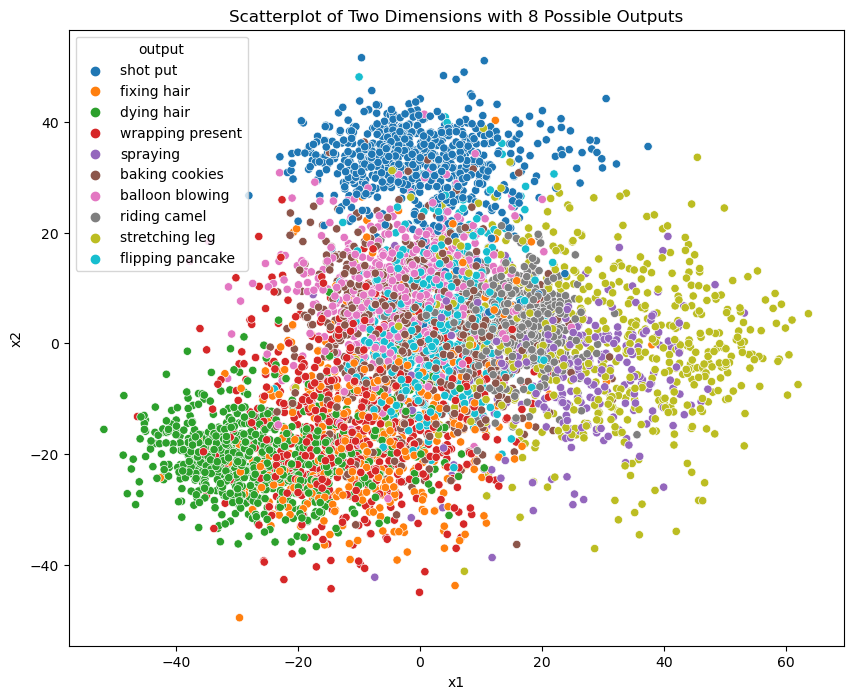

In [19]:
# Crear una instancia de GaussianRandomProjection para reducir la dimensionalidad a 2 componentes
RP = random_projection.GaussianRandomProjection(n_components=2,random_state=12)

# Ajustar el transformador a los datos de entrenamiento escalados y transformarlos
X_train_rp = RP.fit_transform(X_train_s)

# Transformar los datos de validación y testeo escalados utilizando el mismo transformador
X_val_rp = RP.transform(X_val_s)
X_test_rp = RP.transform(X_test_s)

# Mostrar la forma del conjunto de datos transformado de entrenamiento
X_train_rp.shape

# Combinar los datos transformados de entrenamiento con las etiquetas en un DataFrame
df_ = pd.concat([pd.DataFrame(X_train_rp), Y_train], axis = 1)
df_.columns = ["x1","x2","output"] # Asignar nombres a las columnas

# Crear un scatterplot utilizando Seaborn
plt.figure(figsize=(10, 8))
scatter_plot = sns.scatterplot(data=df_, x='x1', y='x2', hue='output')
plt.title('Scatterplot of Two Dimensions with 8 Possible Outputs')
plt.show()

#### UMAP

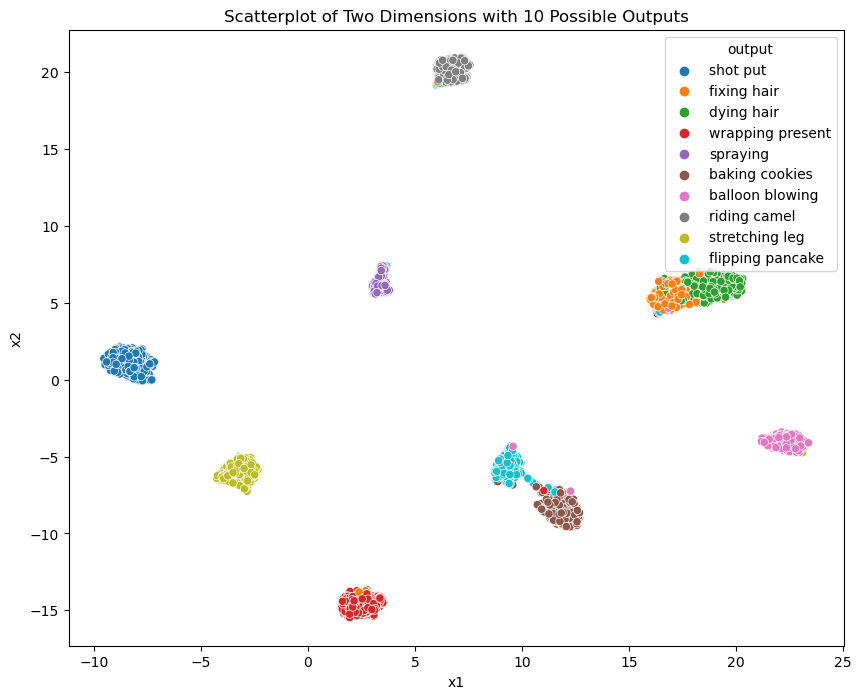

In [21]:
# Crear una instancia de UMAP con una métrica "canberra", un estado aleatorio de 1 y un solo trabajo paralelo
UMAP = umap.UMAP(random_state=1, n_jobs=1, metric="canberra")

# Ajustar el transformador a los datos de entrenamiento escalados y transformarlos
X_train_umap = UMAP.fit_transform(X_train_s)

# Transformar los datos de validación y testeo escalados utilizando el mismo transformador
X_val_umap = UMAP.transform(X_val_s)
X_test_umap = UMAP.transform(X_test_s)

# Mostrar la forma del conjunto de datos transformado de entrenamiento
X_train_umap.shape

# Combinar los datos transformados de entrenamiento con las etiquetas en un DataFrame
df_ = pd.concat([pd.DataFrame(X_train_umap), Y_train], axis = 1)
df_.columns = ["x1","x2","output"]

# Crear un scatterplot utilizando Seaborn
plt.figure(figsize=(10, 8))
scatter_plot = sns.scatterplot(data=df_, x='x1', y='x2', hue='output')
plt.title('Scatterplot of Two Dimensions with 10 Possible Outputs')
plt.show()



#### PCA

(5415, 100)


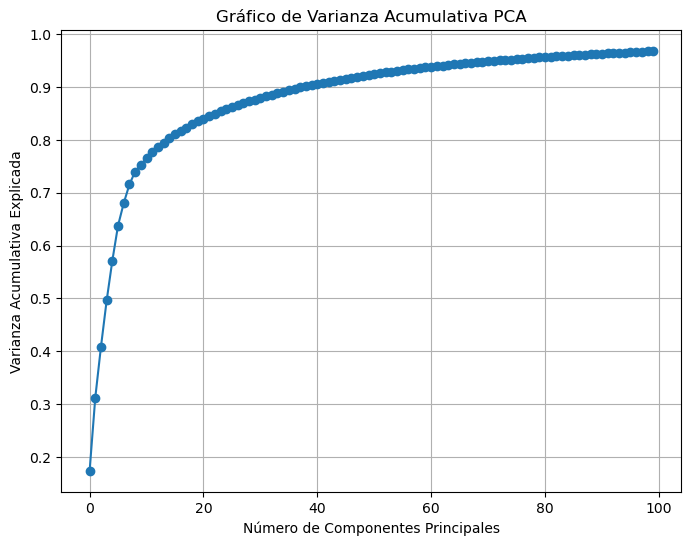

In [23]:
# Crear una instancia de PCA con 100 componentes principales y un estado aleatorio de 12
pca = PCA(n_components=100,random_state=12)

# Ajustar PCA a los datos de entrenamiento y transformarlos
X_train_pca = pca.fit_transform(X_train)

# Transformar los datos de validación y testeo utilizando el PCA ajustado a los datos de entrenamiento
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

# Imprimir la forma del conjunto de datos transformado de entrenamiento
print(X_train_pca.shape)

# Obtener la varianza explicada de cada componente principal
explained_variance = pca.explained_variance_ratio_

# Asumiendo 'explained_variance' ya está definido
# Calcular la varianza acumulativa
cumulative_variance = np.cumsum(explained_variance)

# Crear el gráfico de varianza acumulativa
plt.figure(figsize=(8, 6))
plt.plot(np.arange(0, 100), cumulative_variance[:100], marker='o', linestyle='-')
plt.title('Gráfico de Varianza Acumulativa PCA')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Acumulativa Explicada')
plt.grid(True)
plt.show()

## Función para exportar test

In [25]:
def create_clustered_dataframe(pred, output_csv_path):
    # Convertir predicciones a enteros
    pred = pred.astype(int)

    # Concatenar las predicciones con las URLs de testeo
    test_export = pd.concat([urls_test,pd.DataFrame(pred)], axis=1)
    test_export.columns = ["youtube_id", "labels"]

    # Leer el archivo CSV con los IDs de YouTube para ordenar
    test_url_sort = pd.read_csv(
    "./url_data/test_subset_10.csv", header=None, names=["youtube_id"]
    )

    # Eliminar la primera fila del DataFrame de URLs
    test_url_sort.drop(index=test_url_sort.index[0], axis=0, inplace=True)
    
    # Merge de los dos DataFrames basado en youtube_id
    merged_df = pd.merge(test_url_sort, test_export, on='youtube_id', how='left')

    # Guardar el DataFrame resultante en un nuevo CSV
    merged_df.to_csv(output_csv_path, index=False)
    
def create_clustered_missing_dataframe(pred, output_csv_path):
    # Concatenar las predicciones con las URLs de testeo
    test_export = pd.concat([urls_test, pd.DataFrame(pred)], axis=1)
    test_export.columns = ["youtube_id", "labels"]
    
    # Leer el archivo CSV con los IDs de YouTube para ordenar
    test_url_sort = pd.read_csv(
        "./url_data/test_subset_10.csv", header=None, names=["youtube_id"]
    )

    # Eliminar la primera fila del DataFrame de URLs
    test_url_sort.drop(index=test_url_sort.index[0], axis=0, inplace=True)
    
    # Añadir las filas faltantes con label 0
    missing_ids = test_url_sort[~test_url_sort['youtube_id'].isin(test_export['youtube_id'])]
    missing_ids['labels'] = 0
    
    # Concatenar las filas faltantes al test_export
    test_export = pd.concat([test_export, missing_ids], axis=0)
    
    # Merge de los dos DataFrames basado en youtube_id
    merged_df = pd.merge(test_url_sort, test_export, on='youtube_id', how='left')

    # Guardar el DataFrame resultante en un nuevo CSV
    merged_df.to_csv(output_csv_path, index=False)

## Clustering in 2d

### Kmeans

In [28]:
# Función auxiliar para calcular la distancia Euclidiana entre dos puntos x1 y x2
def distance(x1, x2):
    return np.linalg.norm(x1 - x2, axis=0)
    
class KMeans_:
    def __init__(self, K=5, max_iters=1000, tol=1e-4, random_state=None, init='kmeans++'):
        self.K = K # Número de clusters
        self.max_iters = max_iters # Máximo número de iteraciones
        self.tol = tol  # Tolerancia para la convergencia
        self.random_state = random_state  # Semilla para la reproducibilidad
        self.init = init  # Método de inicialización ('random' o 'kmeans++')

    def fit(self, X):
        if self.random_state is not None:
            np.random.seed(self.random_state)
        
        self.X = X # Conjunto de datos
        self.n_samples, self.n_features = X.shape # Número de muestras y características

        # Inicializar los centroides
        if self.init == 'random':
            random_sample_idxs = np.random.choice(self.n_samples, self.K, replace=False)
            self.centroids = self.X[random_sample_idxs]
        elif self.init == 'kmeans++':
            self.centroids = self._initialize_centroids_kmeanspp()

        for _ in range(self.max_iters):
            # Asignar muestras a los centroides más cercanos (crear clusters)
            labels = self._assign_clusters(self.centroids)

            # Calcular nuevos centroides a partir de los clusters
            centroids_old = self.centroids
            self.centroids = self._calculate_centroids(labels)

            # Verificar convergencia
            if self._is_converged(centroids_old, self.centroids):
                break

    def predict(self, X):
        # Calcular distancias entre las muestras X y los centroides
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        # Devuelve el mas cercano
        return np.argmin(distances, axis=1)

    def _assign_clusters(self, centroids):
        # Calcular distancias entre todas las muestras y los centroides
        distances = np.linalg.norm(self.X[:, np.newaxis] - centroids, axis=2)
        # Devuelve el mas cercano
        return np.argmin(distances, axis=1)

    def _calculate_centroids(self, labels):
        centroids = np.zeros((self.K, self.n_features))
        for k in range(self.K):
            cluster_points = self.X[labels == k] # Muestras asignadas al cluster k
            if len(cluster_points) > 0:
                centroids[k] = cluster_points.mean(axis=0)  # Calcular nuevo centroide como la media del cluster
        return centroids

    def _is_converged(self, centroids_old, centroids):
        # Verificar si la suma de las distancias entre los centroides antiguos y nuevos es menor que la tolerancia
        distances = np.linalg.norm(centroids_old - centroids, axis=1)
        return np.all(distances < self.tol)
    
    def _initialize_centroids_kmeanspp(self):
        centroids = []
        # Paso 1: Seleccionar aleatoriamente el primer centroide de los puntos de datos
        first_centroid_idx = np.random.choice(self.n_samples)
        centroids.append(self.X[first_centroid_idx])
        for _ in range(1, self.K):
            # Paso 2: Calcular la distancia entre cada punto y el centroide más cercano
            distances = np.min([np.linalg.norm(self.X - c, axis=1) for c in centroids], axis=0)
            # Paso 3: Seleccionar el siguiente centroide con una probabilidad proporcional al cuadrado de la distancia
            probabilities = distances ** 2 / np.sum(distances ** 2)
            next_centroid_idx = np.random.choice(self.n_samples, p=probabilities)
            centroids.append(self.X[next_centroid_idx])
        
        return np.array(centroids)

In [29]:
def plot_scatter_kmeans(X, model, labels):
    #  Función para graficar un scatter plot de los datos junto con los centroides del modelo K-means.
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
    ax.scatter(model.centroids[:, 0], model.centroids[:, 1],
           marker='.', color='black', s=100 , linewidths=3)
    ax.set_title("K-means Clustering")
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")

    plt.show()



#### Train

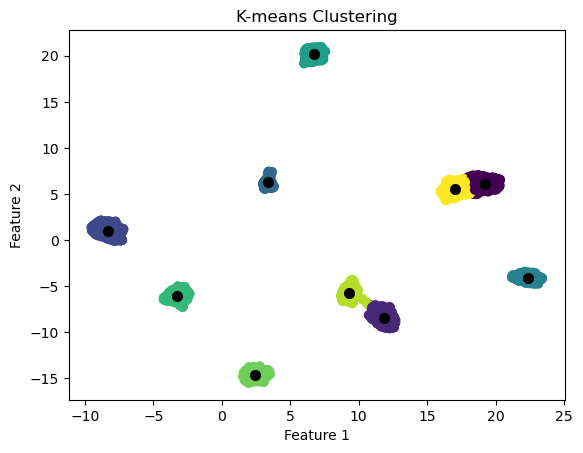

In [31]:
# Instanciar KMeans con 10 clusters y semilla aleatoria 11
kmeans = KMeans_(K=10, random_state=11)
kmeans.fit(X_train_umap)

# Instanciar LabelEncoder
le = LabelEncoder()
train_pred = kmeans.predict(X_train_umap)
train_labels = le.fit_transform(np.array(Y_train).reshape(Y_train.shape[0]))

# Graficar scatter plot con los resultados de K-means
plot_scatter_kmeans(X_train_umap, kmeans, train_pred)

#### Val

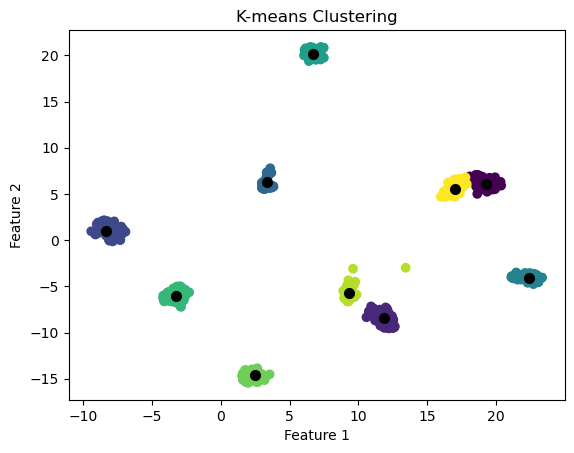

In [33]:
val_pred = kmeans.predict(X_val_umap)
val_labels = le.fit_transform(np.array(Y_val).reshape(Y_val.shape[0]))

plot_scatter_kmeans(X_val_umap, kmeans, val_pred)

#### Results

In [35]:
print(adjusted_rand_score(val_labels, val_pred))
print(silhouette_score(X_val_umap, val_pred))
print(adjusted_mutual_info_score(val_labels, val_pred))

0.8773269850438794
0.8042683
0.8934080320626316


#### Test classification

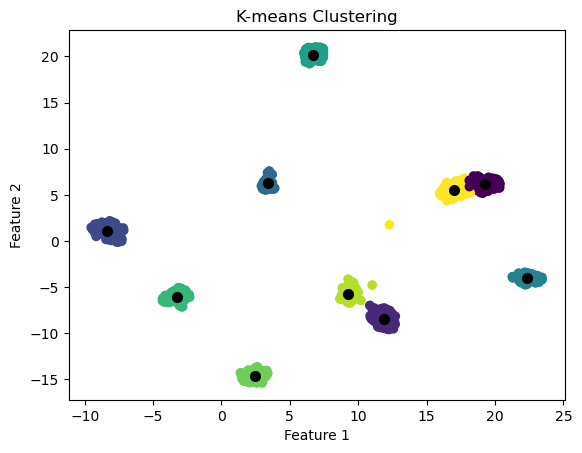

In [37]:
test_pred = kmeans.predict(X_test_umap)
plot_scatter_kmeans(X_test_umap, kmeans, test_pred)
create_clustered_dataframe(test_pred,'./Predictions/r2plus1d_34_8_ig65m_ft_kinetics/test_output_2d_kmeanspp.csv')


### Dbscan

In [39]:
class DBSCAN_:
    def __init__(self, radius=1, min_neighbors=5,random_state=None):
        self.radius = radius
        self.min_neighbors = min_neighbors
        self.labels_ = None  # Etiquetas finales asignadas a cada punto después del ajuste
        self.tree_ = None # Estructura de datos para búsqueda eficiente de vecinos
        self.data_ = None # Datos de entrada
        self.random_state = random_state  # Semilla para la reproducibilidad

    def fit(self, data):
        if self.random_state is not None:
            np.random.seed(self.random_state)
        self.data_ = data
        self.tree_ = KDTree(data) # Construye un KDTree para búsqueda eficiente de vecinos
        n, _ = data.shape
        counter = 0
        labels = [-1 for _ in range(n)] # Inicializa todas las etiquetas como ruido (-1)
        label_count = -1 # Contador de etiquetas de clusters
        stack = [0] # Pila para seguir expandiendo clusters

        while True:
            if len(stack) == 0:
                try:
                    stack.append(labels.index(-1)) # Agrega puntos no etiquetados a la pila
                except ValueError:
                    self.labels_ = labels # Asigna las etiquetas finales al modelo
                    return self
            current_index = stack.pop() # Toma el siguiente punto de la pila

            if labels[current_index] == -1:
                counter += 1
                neighbors = self.tree_.query_radius([data[current_index]], r=self.radius)[0] #Busqueda por radio de vecinos cercanos
                n_neighbors = len(neighbors)
                if n_neighbors < self.min_neighbors:
                    labels[current_index] = -np.inf # Marca como ruido si no tiene suficientes vecinos
                else:
                    #Marcar index actual con el label
                    label_count += 1
                    labels[current_index] = label_count
                    for v in neighbors:
                        if labels[v] == -1:
                            stack.append(v)
                            labels[v] = label_count
                        if labels[v] == -np.inf:
                            labels[v] = label_count
            else:
                neighbors = self.tree_.query_radius([data[current_index]], r=self.radius)[0]
                for v in neighbors:
                    if labels[v] == -1:
                        counter += 1
                        stack.append(v)
                        labels[v] = label_count
                    if labels[v] == -np.inf:
                        labels[v] = label_count

        self.labels_ = labels
        return self

    def predict(self, data):
        if self.labels_ is None:
            raise ValueError("Model has not been fitted yet.")
        tree = KDTree(self.data_)
        labels = [-1 for _ in range(len(data))]
        for i, point in enumerate(data):
            neighbors = tree.query_radius([point], r=self.radius)[0]
            cluster_labels = [self.labels_[neighbor] for neighbor in neighbors if self.labels_[neighbor] >= 0]
            if cluster_labels:
                labels[i] = max(set(cluster_labels), key=cluster_labels.count)
        return np.array(labels)

In [40]:
def plot_scatter_dbscan(X, labels):
    # Convert labels to an array for easier manipulation
    labels = np.array(labels)
    
    # Determine the colors for each label
    unique_labels = set(labels)
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))
    color_dict = {label: color for label, color in zip(unique_labels, colors)}

    # Override the color for label -1 to be gray
    color_dict[-1] = 'gray'
    
    # Create a list of colors based on labels
    point_colors = [color_dict[label] for label in labels]

    # Plot the data points with assigned colors
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(X[:, 0], X[:, 1], c=point_colors)

    ax.set_title("DBSCAN Clustering")
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")

    plt.show()



#### Train

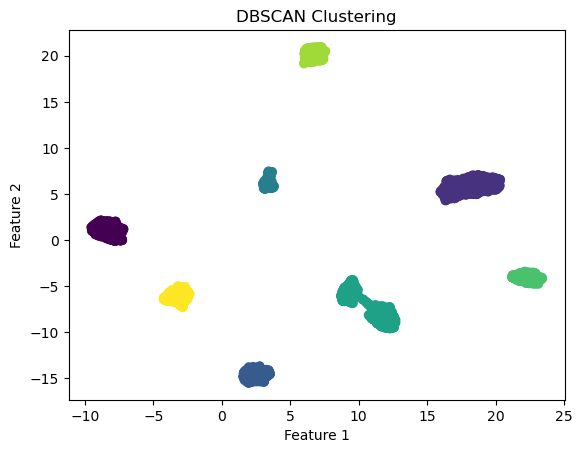

In [42]:
dbscan = DBSCAN_(random_state=12) #play with radius
dbscan.fit(X_train_umap)
# Instanciar LabelEncoder
le = LabelEncoder()
train_pred = dbscan.predict(X_train_umap)
train_labels = le.fit_transform(np.array(Y_train).reshape(Y_train.shape[0]))

plot_scatter_dbscan(X_train_umap, train_pred)

#### Val

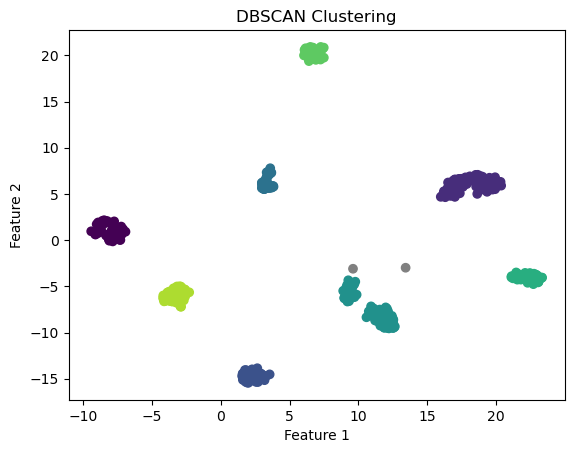

In [44]:
val_pred = dbscan.predict(X_val_umap)
val_labels = le.fit_transform(np.array(Y_val).reshape(Y_val.shape[0]))

plot_scatter_dbscan(X_val_umap, val_pred)

#### Results

In [46]:
print(adjusted_rand_score(val_labels, val_pred))
print(silhouette_score(X_val_umap, val_pred))
print(adjusted_mutual_info_score(val_labels, val_pred))

0.7718280319309319
0.8017086
0.8802527654824114


#### Test classification

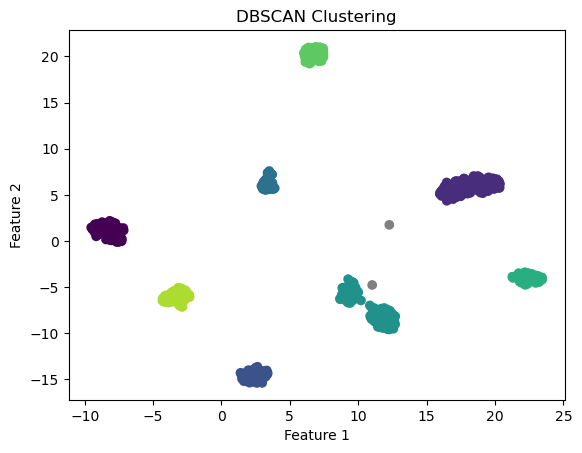

In [48]:
test_pred = dbscan.predict(X_test_umap)
plot_scatter_dbscan(X_test_umap, test_pred)
create_clustered_dataframe(np.where(test_pred < 0, 0, test_pred),'./Predictions/r2plus1d_34_8_ig65m_ft_kinetics/test_output_2d_dbscan.csv')


### Gaussian-Mixture

In [50]:
class GaussianMixtureModel_:
    def __init__(self, k=3, epochs=1000, err=1e-5, random_state=None):
        self.k = k # Número de componentes gaussianas (clusters) en el modelo.
        self.epochs = epochs # Número máximo de iteraciones (épocas) para el entrenamiento.
        self.err = err # Error provocado a proposito para evitar overfitting
        self.random_state = random_state # Semilla para la reproducibilidad de los resultados aleatorios.
        self.centroids = None
        self.pi = None
        self.complete_covariance = None

    def fit(self, data):
        n_samples, n_features = data.shape

        # Initialize with KMeans++
 
        kmeans = KMeans_(K=self.k, random_state=self.random_state)

        kmeans.fit(data)
        self.centroids = kmeans.centroids

        self.pi = np.full(self.k, 1.0 / self.k)   # Inicializa los priors de forma uniforme
        self.complete_covariance = np.array([np.identity(n_features) for _ in range(self.k)])  # Inicializa las covarianzas
        max_log_likelihood = -np.inf
        best_centroids = self.centroids
        best_covariance = self.complete_covariance
        best_pi = self.pi

        for _ in range(self.epochs):
            # E-Step: Computar responsabilidades (gamma_nk)
            gaussian_result = np.zeros((self.k, n_samples))
            for i in range(self.k):
                gaussian_result[i, :] = self.multivariate_gaussian(data, self.centroids[i], self.complete_covariance[i])

            sum_nk = np.dot(self.pi, gaussian_result)
            gamma_nk = (self.pi[:, np.newaxis] * gaussian_result) / (sum_nk + self.err)

            # M-Step: Actualizar parametros
            self.pi = gamma_nk.sum(axis=1) / n_samples
            self.centroids = np.dot(gamma_nk, data) / gamma_nk.sum(axis=1)[:, np.newaxis]

            for i in range(self.k):
                diff = data - self.centroids[i]
                self.complete_covariance[i] = np.dot(gamma_nk[i] * diff.T, diff) / gamma_nk[i].sum()
                self.complete_covariance[i] += np.eye(n_features) * self.err

            # Log likelihood (A mas positivo mejor indica el progreso del modelo. Puede ser negativo)
            log_likelihood = np.sum(np.log(sum_nk + self.err))
            if log_likelihood > max_log_likelihood:
                max_log_likelihood = log_likelihood
                best_centroids = self.centroids
                best_covariance = self.complete_covariance
                best_pi = self.pi

        self.centroids = best_centroids
        self.complete_covariance = best_covariance
        self.pi = best_pi

    def multivariate_gaussian(self, data, mu, cov):
        n = data.shape[1]
        cov += np.eye(n) * self.err # Regularización para estabilidad numérica

        #Formula de stackoverflow + https://towardsdatascience.com/gaussian-mixture-models-explained-6986aaf5a95
        diff = data - mu
        inv_cov = np.linalg.inv(cov)
        norm_factor = np.sqrt((2 * np.pi) ** n * np.linalg.det(cov))
        exp_factor = np.exp(-0.5 * np.sum(np.dot(diff, inv_cov) * diff, axis=1)) 
        return exp_factor / norm_factor

    def compute_gammank_gaussian(self, data):
        gaussian_result = np.zeros((self.k, len(data)))
        #Para cada gaussiana
        for i in range(self.k):
            #Calcular su resultado (meter el array dentro de una matriz 3D)
            gaussian_result[i, :] = self.multivariate_gaussian(data, self.centroids[i], self.complete_covariance[i])
        sum_nk = np.dot(self.pi, gaussian_result)
        gamma_nk = (self.pi[:, np.newaxis] * gaussian_result) / (sum_nk + self.err)
        return gamma_nk

    def predict(self, data):
        gamma = self.compute_gammank_gaussian(data)
        return np.argmax(gamma, axis=0)


In [51]:
def plot_gaussian_mixture(data, model, labels):
    plt.figure(figsize=(10, 6))
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', marker='o', edgecolor='k', alpha=0.6)

    for i in range(model.k):
        plot_cov_ellipse(model.complete_covariance[i], model.centroids[i], nstd=2, alpha=0.5, edgecolor='red')

    plt.scatter(model.centroids[:, 0], model.centroids[:, 1], c='white', marker='.', s=100, linewidths=3)
    plt.title('Distribución de Clases Predichas y Elipses de Covarianza')
    plt.xlabel('Característica 1')
    plt.ylabel('Característica 2')
    plt.show()

def plot_cov_ellipse(cov, pos, nstd=2, **kwargs):
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
    width, height = 2 * nstd * np.sqrt(eigvals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=angle, **kwargs)
    ax = plt.gca()
    ax.add_artist(ellip)

#### Train

In [53]:
GMM = GaussianMixtureModel_(k=10,random_state=11)
GMM.fit(X_train_umap)

In [54]:
train_pred = GMM.predict(X_train_umap)
train_labels = le.fit_transform(np.array(Y_train).reshape(Y_train.shape[0]))

#### Val

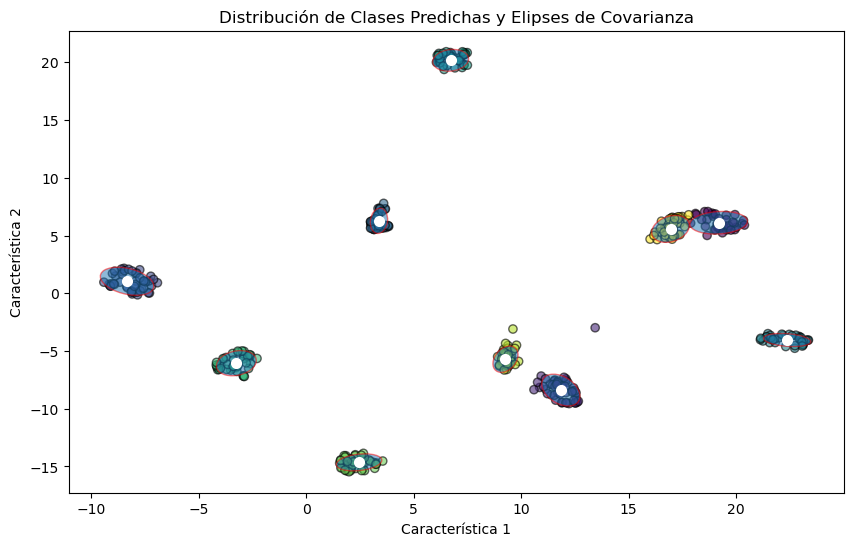

In [56]:
val_pred = GMM.predict(X_val_umap)
val_labels = le.fit_transform(np.array(Y_val).reshape(Y_val.shape[0]))

plot_gaussian_mixture(X_val_umap, GMM, val_pred)

#### Results

In [58]:
print(adjusted_rand_score(val_labels, val_pred))
print(silhouette_score(X_val_umap, val_pred))
print(adjusted_mutual_info_score(val_labels,val_pred))

0.8806913033819346
0.80121595
0.8951679386655589


#### Test classification

In [60]:
test_pred = GMM.predict(X_test_umap)
create_clustered_dataframe(test_pred,'./Predictions/r2plus1d_34_8_ig65m_ft_kinetics/test_output_2d_gmm.csv')

## Clustering in 50d

In [62]:
UMAP = umap.UMAP(n_components=50,random_state=1, n_jobs=1, metric = "canberra")
X_train_umap = UMAP.fit_transform(X_train_s)
X_val_umap = UMAP.transform(X_val_s)
X_test_umap = UMAP.transform(X_test_s)

### Kmeans

#### Train

In [65]:
# Definir y ajustar el modelo de KMeansUTEC
kmeans = KMeans_(K=10, random_state=10)
kmeans.fit(X_train_umap)
# Instanciar LabelEncoder
le = LabelEncoder()
train_pred = kmeans.predict(X_train_umap)
train_labels = le.fit_transform(np.array(Y_train).reshape(Y_train.shape[0]))

#### Val

In [67]:
val_pred = kmeans.predict(X_val_umap)
val_labels = le.fit_transform(np.array(Y_val).reshape(Y_val.shape[0]))


#### Results

In [69]:
print(adjusted_rand_score(val_labels, val_pred))
print(silhouette_score(X_val_umap, val_pred))
print(adjusted_mutual_info_score(val_labels,val_pred))

0.7998101490817751
0.83728236
0.879061200169457


#### Test classification

In [71]:
test_pred = kmeans.predict(X_test_umap)
create_clustered_dataframe(test_pred,'./Predictions/r2plus1d_34_8_ig65m_ft_kinetics/test_output_50d_kmeanspp.csv')


### Dbscan

#### Train

In [74]:
dbscan = DBSCAN_(random_state=12)
dbscan.fit(X_train_umap)
# Instanciar LabelEncoder
le = LabelEncoder()
train_pred = dbscan.predict(X_train_umap)
train_labels = le.fit_transform(np.array(Y_train).reshape(Y_train.shape[0]))

#### Val

In [76]:
val_pred = dbscan.predict(X_val_umap)
val_labels = le.fit_transform(np.array(Y_val).reshape(Y_val.shape[0]))

#### Results

In [78]:
print(adjusted_rand_score(val_labels, val_pred))
print(silhouette_score(X_val_umap, val_pred))
print(adjusted_mutual_info_score(val_labels,val_pred))

0.8375991783626753
0.8669846
0.898903466501315


#### Test classification

In [80]:
test_pred = dbscan.predict(X_test_umap)
create_clustered_dataframe(np.where(test_pred < 0, 0, test_pred),'./Predictions/r2plus1d_34_8_ig65m_ft_kinetics/test_output_50d_dbscan.csv')


### Gaussian-Mixture

#### Train

In [83]:
GMM = GaussianMixtureModel_(k=10,random_state=10)
GMM.fit(X_train_umap)

In [84]:
train_pred = GMM.predict(X_train_umap)
train_labels = le.fit_transform(np.array(Y_train).reshape(Y_train.shape[0]))

#### Val

In [86]:
val_pred = GMM.predict(X_val_umap)
val_labels = le.fit_transform(np.array(Y_val).reshape(Y_val.shape[0]))

#### Results

In [88]:
print(adjusted_rand_score(val_labels, val_pred))
print(silhouette_score(X_val_umap, val_pred))
print(adjusted_mutual_info_score(val_labels,val_pred))

0.8001493294819066
0.81564116
0.8766060393222067


#### Test classification

In [90]:
test_pred = GMM.predict(X_test_umap)
create_clustered_dataframe(test_pred,'./Predictions/r2plus1d_34_8_ig65m_ft_kinetics/test_output_50d_gmm.csv')

# Dataset r2plus1d_34_32_ig65m_ft_kinetics

## Procesar los features extraídos

### Obtener un feature vector por cada video

In [94]:

df_train_labels = pd.read_csv(
    "./url_data/train_subset_10.csv", header=None, names=["youtube_id", "label"]
)
df_val_labels = pd.read_csv(
    "./url_data/val_subset_10.csv", header=None, names=["youtube_id", "label"]
)
df_test_labels = pd.read_csv(
    "./url_data/test_subset_10.csv", header=None, names=["youtube_id", "label"]
)
df_train_labels.drop(index=df_train_labels.index[0], axis=0, inplace=True)
df_val_labels.drop(index=df_val_labels.index[0], axis=0, inplace=True)
df_test_labels.drop(index=df_test_labels.index[0], axis=0, inplace=True)

df_test_labels.head()

,youtube_id,label
1,oaVWnxlQOeo,NaN
2,7zMBk9Zu9fY,NaN
3,DwPEZeX5WkA,NaN
4,bO1MW9Lq9Sg,NaN
5,TdBpD9Ccg9w,NaN


### Obtener la data de entrenamiento, validación y de testeo

In [96]:
models_r21d = ["r2plus1d_18_16_kinetics","r2plus1d_34_32_ig65m_ft_kinetics","r2plus1d_34_8_ig65m_ft_kinetics"]
urls_train, X_train, Y_train = process_video_data(
    f"./Data Extracted/numpy_data/train/r21d/{models_r21d[1]}/", df_train_labels
)

urls_train.dropna(inplace=True)
X_train.dropna(inplace=True)
Y_train.dropna(inplace=True)

print(f"\nNúmero de videos cargados para entrenamiento: {len(X_train)}")
print(f"Shape de nuestra matriz de videos para entrenamiento: {X_train.shape}")


Number of empty videos not included (./Data Extracted/numpy_data/train/r21d/r2plus1d_34_32_ig65m_ft_kinetics/): 6
Labels of empty videos not included: ['EQULJzMzmeM', 'W6TspTTHpzA', '-reNwipPPdQ', 'oRwkPwoFIL8', 'yqJXWU8BXEQ', 'B3L0x-AsCZ4']

Número de videos cargados para entrenamiento: 5409
Shape de nuestra matriz de videos para entrenamiento: (5409, 512)


In [97]:
urls_val, X_val, Y_val = process_video_data(
    f"./Data Extracted/numpy_data/val/r21d/{models_r21d[1]}/", df_val_labels
)

urls_val.dropna(inplace=True)
X_val.dropna(inplace=True)
Y_val.dropna(inplace=True)

print(f"\nNúmero de videos cargados para validación: {len(X_val)}")
print(f"Shape de nuestra matriz de videos para validación: {X_val.shape}")


Number of empty videos not included (./Data Extracted/numpy_data/val/r21d/r2plus1d_34_32_ig65m_ft_kinetics/): 0
Labels of empty videos not included: []

Número de videos cargados para validación: 426
Shape de nuestra matriz de videos para validación: (426, 512)


In [98]:
urls_test, X_test, Y_test = process_video_data(
    f"./Data Extracted/numpy_data/test/r21d/{models_r21d[1]}/", df_test_labels
)
urls_test.dropna(inplace=True)
X_test.dropna(inplace=True)
Y_test.dropna(inplace=True)

print(f"\nNúmero de videos cargados para testeo: {len(X_test)}")
print(f"Shape de nuestra matriz de videos para testeo: {X_test.shape}")

Number of empty videos not included (./Data Extracted/numpy_data/test/r21d/r2plus1d_34_32_ig65m_ft_kinetics/): 1
Labels of empty videos not included: ['se3ihwZ56Uw']

Número de videos cargados para testeo: 804
Shape de nuestra matriz de videos para testeo: (804, 512)


## Preprocesamiento de la data

### Escalar los datos

In [101]:
Scaler = PowerTransformer(method="yeo-johnson") # Utilizaremos el PowerTransformer para asemejar la data a una forma gaussiana
X_train_s = Scaler.fit_transform(X_train)
X_val_s = Scaler.transform(X_val)
X_test_s = Scaler.transform(X_test)


### Reduce dimensionality

#### Random Projection

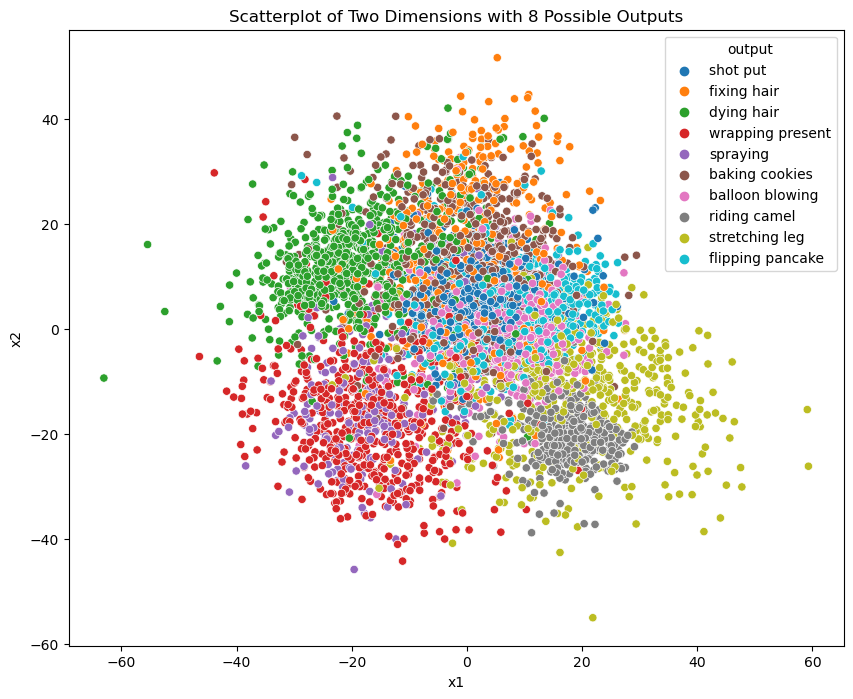

In [104]:
RP = random_projection.GaussianRandomProjection(n_components=2,random_state=12)
X_train_rp = RP.fit_transform(X_train_s)
X_val_rp = RP.transform(X_val_s)
X_test_rp = RP.transform(X_test_s)
X_train_rp.shape
df_ = pd.concat([pd.DataFrame(X_train_rp), Y_train], axis = 1)
df_.columns = ["x1","x2","output"]
# Crear el scatterplot con Seaborn
plt.figure(figsize=(10, 8))
scatter_plot = sns.scatterplot(data=df_, x='x1', y='x2', hue='output')
plt.title('Scatterplot of Two Dimensions with 8 Possible Outputs')
plt.show()

#### UMAP

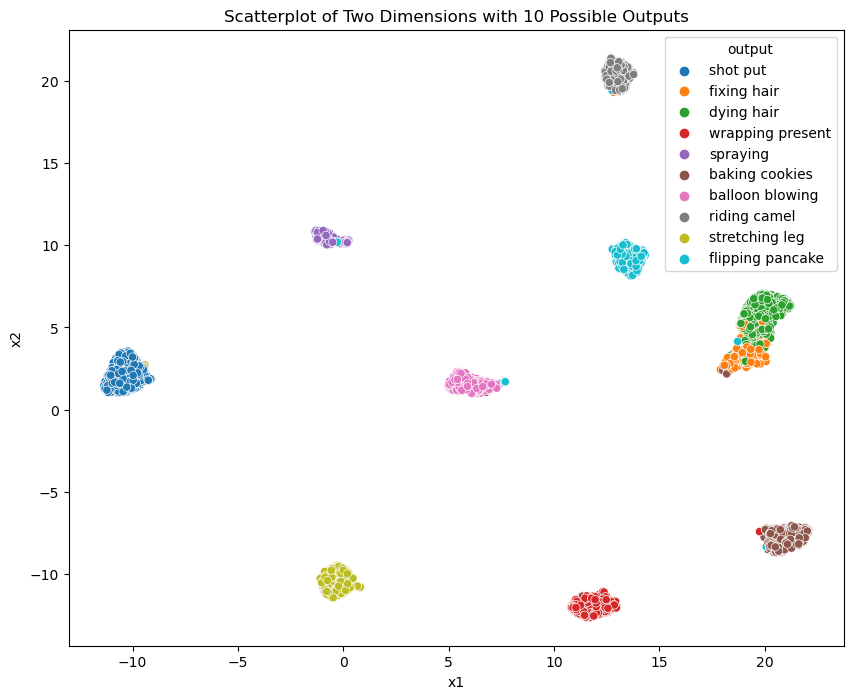

In [106]:
UMAP = umap.UMAP(random_state=1, n_jobs=1, metric="canberra")
X_train_umap = UMAP.fit_transform(X_train_s)
X_val_umap = UMAP.transform(X_val_s)
X_test_umap = UMAP.transform(X_test_s)
X_train_umap.shape
df_ = pd.concat([pd.DataFrame(X_train_umap), Y_train], axis = 1)
df_.columns = ["x1","x2","output"]
# Crear el scatterplot con Seaborn
plt.figure(figsize=(10, 8))
scatter_plot = sns.scatterplot(data=df_, x='x1', y='x2', hue='output')
plt.title('Scatterplot of Two Dimensions with 10 Possible Outputs')
plt.show()

#### PCA

(5409, 100)


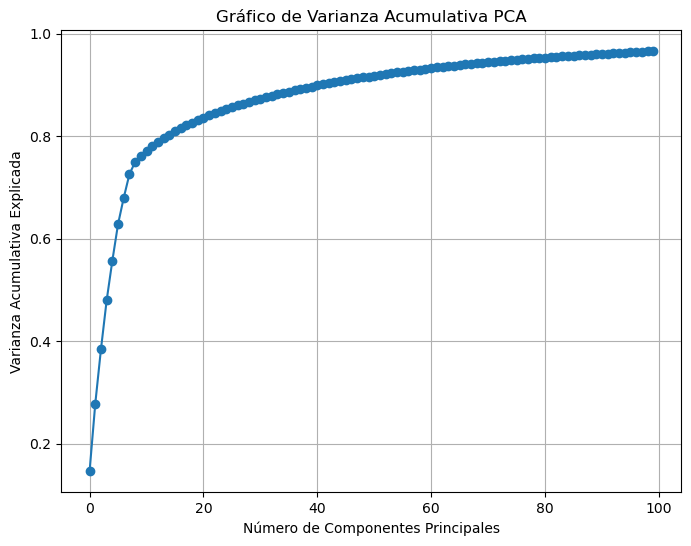

In [108]:
pca = PCA(n_components=100,random_state=12)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)
print(X_train_pca.shape)

explained_variance = pca.explained_variance_ratio_
# Assuming 'explained_variance' is already defined
cumulative_variance = np.cumsum(explained_variance)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(np.arange(0, 100), cumulative_variance[:100], marker='o', linestyle='-')
plt.title('Gráfico de Varianza Acumulativa PCA')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Acumulativa Explicada')
plt.grid(True)
plt.show()

In [109]:
def create_clustered_dataframe(pred, output_csv_path):
    test_export = pd.concat([urls_test,pd.DataFrame(pred)], axis=1)
    test_export.columns = ["youtube_id", "labels"]
    test_url_sort = pd.read_csv(
    "./url_data/test_subset_10.csv", header=None, names=["youtube_id"]
    )
    test_url_sort.drop(index=test_url_sort.index[0], axis=0, inplace=True)
    
    # Merge de los dos DataFrames basado en youtube_id
    merged_df = pd.merge(test_url_sort, test_export, on='youtube_id', how='left')

    # Guardar el DataFrame resultante en un nuevo CSV
    merged_df.to_csv(output_csv_path, index=False)
    
def create_clustered_missing_dataframe(pred, output_csv_path):
    test_export = pd.concat([urls_test, pd.DataFrame(pred)], axis=1)
    test_export.columns = ["youtube_id", "labels"]
    
    test_url_sort = pd.read_csv(
        "./url_data/test_subset_10.csv", header=None, names=["youtube_id"]
    )
    test_url_sort.drop(index=test_url_sort.index[0], axis=0, inplace=True)
    
    # Añadir las filas faltantes con label 0
    missing_ids = test_url_sort[~test_url_sort['youtube_id'].isin(test_export['youtube_id'])]
    missing_ids['labels'] = 0
    
    # Concatenar las filas faltantes al test_export
    test_export = pd.concat([test_export, missing_ids], axis=0)
    
    # Merge de los dos DataFrames basado en youtube_id
    merged_df = pd.merge(test_url_sort, test_export, on='youtube_id', how='left')

    # Guardar el DataFrame resultante en un nuevo CSV
    merged_df.to_csv(output_csv_path, index=False)

## Clustering in 2d

### Kmeans

#### Train

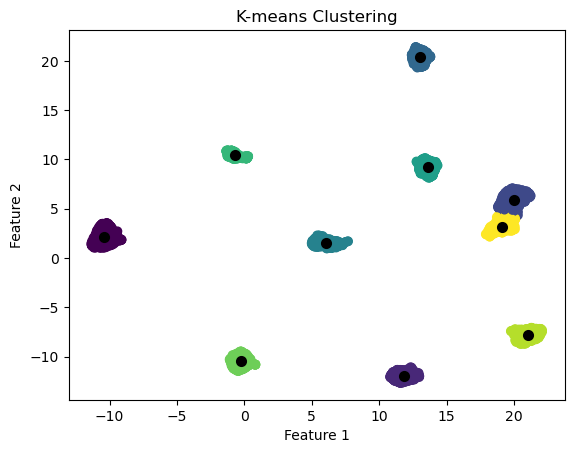

In [113]:
kmeans = KMeans_(K=10, random_state=12)
kmeans.fit(X_train_umap)
# Instanciar LabelEncoder
le = LabelEncoder()
train_pred = kmeans.predict(X_train_umap)
train_labels = le.fit_transform(np.array(Y_train).reshape(Y_train.shape[0]))

plot_scatter_kmeans(X_train_umap, kmeans, train_pred)

#### Val

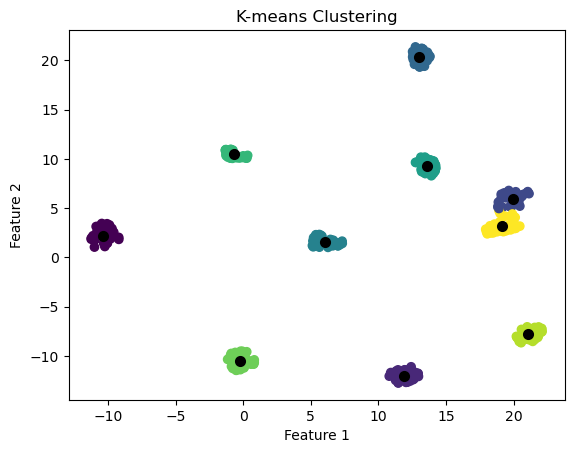

In [115]:
val_pred = kmeans.predict(X_val_umap)
val_labels = le.fit_transform(np.array(Y_val).reshape(Y_val.shape[0]))

plot_scatter_kmeans(X_val_umap, kmeans, val_pred)

#### Results

In [117]:
print(adjusted_rand_score(val_labels, val_pred))
print(silhouette_score(X_val_umap, val_pred))
print(adjusted_mutual_info_score(val_labels,val_pred))

0.8958875581509722
0.85272396
0.915550978742791


#### Test classification

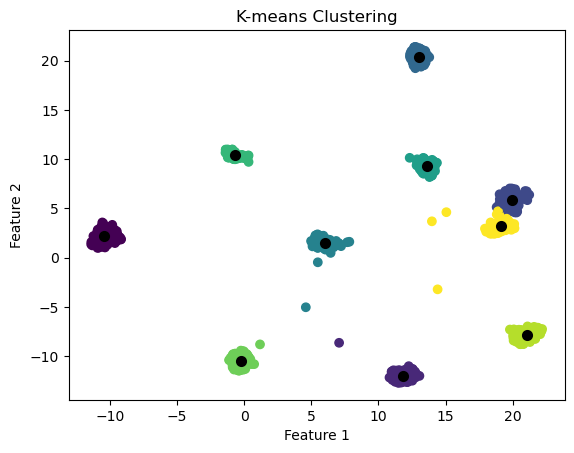

/var/folders/80/pl2pdk595tgbq9tgh3qh84kc0000gn/T/ipykernel_96613/1532207649.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_ids['labels'] = 0


In [119]:
test_pred = kmeans.predict(X_test_umap)
plot_scatter_kmeans(X_test_umap, kmeans, test_pred)
create_clustered_missing_dataframe(test_pred,'./Predictions/r2plus1d_34_32_ig65m_ft_kinetics/test_output_2d_kmeanspp.csv')

### Dbscan

#### Train

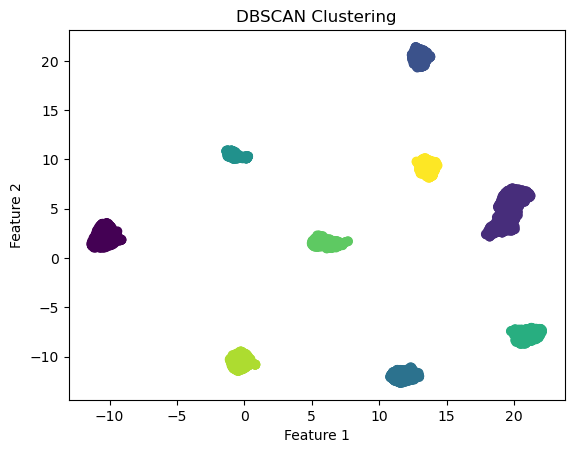

In [122]:
dbscan = DBSCAN_(random_state=11)
dbscan.fit(X_train_umap)
# Instanciar LabelEncoder
le = LabelEncoder()
train_pred = dbscan.predict(X_train_umap)
train_labels = le.fit_transform(np.array(Y_train).reshape(Y_train.shape[0]))

plot_scatter_dbscan(X_train_umap, train_pred)

#### Val

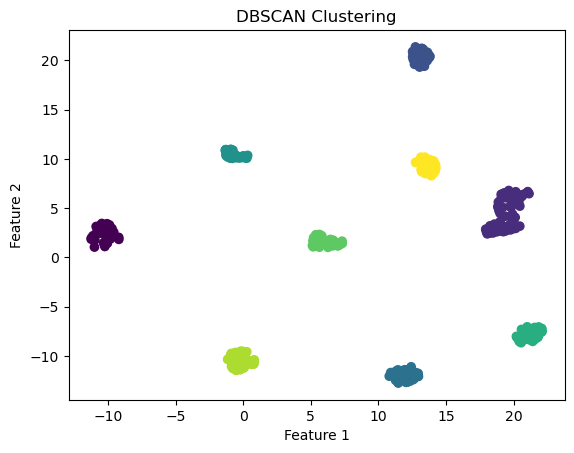

In [124]:
val_pred = dbscan.predict(X_val_umap)
val_labels = le.fit_transform(np.array(Y_val).reshape(Y_val.shape[0]))

plot_scatter_dbscan(X_val_umap, val_pred)

#### Results

In [126]:
print(adjusted_rand_score(val_labels, val_pred))
print(silhouette_score(X_val_umap, val_pred))
print(adjusted_mutual_info_score(val_labels,val_pred))

0.8550387000745657
0.8782363
0.918766852100168


#### Test classification

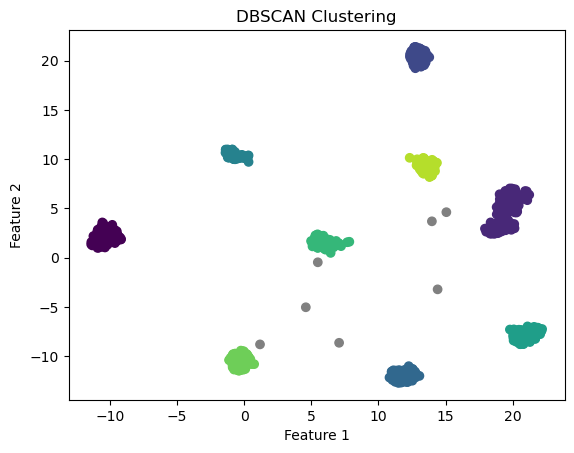

/var/folders/80/pl2pdk595tgbq9tgh3qh84kc0000gn/T/ipykernel_96613/1532207649.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_ids['labels'] = 0


In [128]:
test_pred = dbscan.predict(X_test_umap)
plot_scatter_dbscan(X_test_umap, test_pred)
create_clustered_missing_dataframe(np.where(test_pred < 0, 0, test_pred),'./Predictions/r2plus1d_34_32_ig65m_ft_kinetics/test_output_2d_dbscan.csv')


### Gaussian-Mixture

#### Train

In [131]:
GMM = GaussianMixtureModel_(k=10, random_state=12)
GMM.fit(X_train_umap)

In [132]:
train_pred = GMM.predict(X_train_umap)
train_labels = le.fit_transform(np.array(Y_train).reshape(Y_train.shape[0]))

#### Val

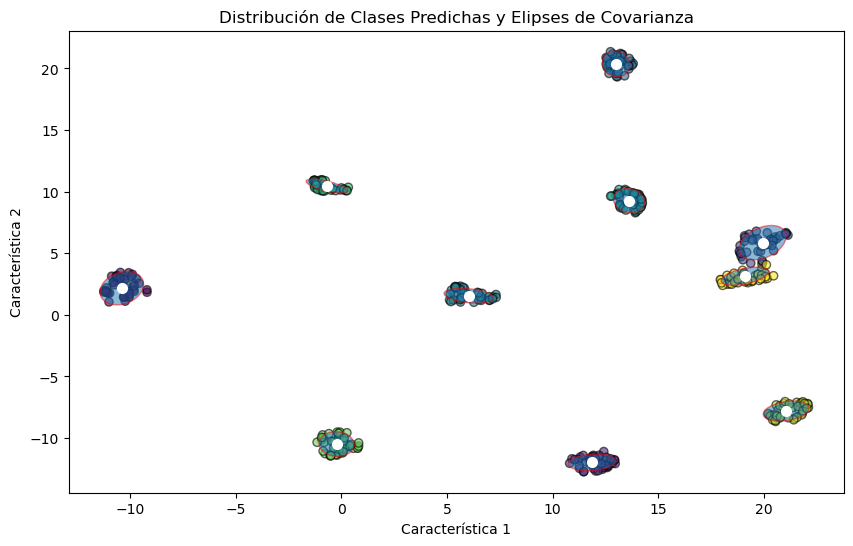

In [134]:
val_pred = GMM.predict(X_val_umap)
val_labels = le.fit_transform(np.array(Y_val).reshape(Y_val.shape[0]))

plot_gaussian_mixture(X_val_umap, GMM, val_pred)

#### Results

In [136]:
print(adjusted_rand_score(val_labels, val_pred))
print(silhouette_score(X_val_umap, val_pred))
print(adjusted_mutual_info_score(val_labels,val_pred))

0.9004010994538306
0.8500172
0.9171397659161197


#### Test classification

In [138]:
test_pred = GMM.predict(X_test_umap)
create_clustered_missing_dataframe(test_pred,'./Predictions/r2plus1d_34_32_ig65m_ft_kinetics/test_output_2d_gmm.csv')

/var/folders/80/pl2pdk595tgbq9tgh3qh84kc0000gn/T/ipykernel_96613/1532207649.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_ids['labels'] = 0


## Clustering in 50d

In [140]:
UMAP = umap.UMAP(n_components=50,random_state=1, n_jobs=1, metric="canberra")
X_train_umap = UMAP.fit_transform(X_train_s)
X_val_umap = UMAP.transform(X_val_s)
X_test_umap = UMAP.transform(X_test_s)

### Kmeans

#### Train

In [143]:
kmeans = KMeans_(K=10, random_state=10)
kmeans.fit(X_train_umap)
# Instanciar LabelEncoder
le = LabelEncoder()
train_pred = kmeans.predict(X_train_umap)
train_labels = le.fit_transform(np.array(Y_train).reshape(Y_train.shape[0]))

#### Val

In [145]:
val_pred = kmeans.predict(X_val_umap)
val_labels = le.fit_transform(np.array(Y_val).reshape(Y_val.shape[0]))


#### Results

In [147]:
print(adjusted_rand_score(val_labels, val_pred))
print(silhouette_score(X_val_umap, val_pred))
print(adjusted_mutual_info_score(val_labels,val_pred))

0.8210085356130185
0.87220466
0.9028176282083618


#### Test classification

In [149]:
test_pred = kmeans.predict(X_test_umap)
create_clustered_missing_dataframe(test_pred,'./Predictions/r2plus1d_34_32_ig65m_ft_kinetics/test_output_50d_kmeanspp.csv')


/var/folders/80/pl2pdk595tgbq9tgh3qh84kc0000gn/T/ipykernel_96613/1532207649.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_ids['labels'] = 0


### Dbscan

#### Train

In [152]:
dbscan = DBSCAN_(random_state=11)
dbscan.fit(X_train_umap)
# Instanciar LabelEncoder
le = LabelEncoder()
train_pred = dbscan.predict(X_train_umap)
train_labels = le.fit_transform(np.array(Y_train).reshape(Y_train.shape[0]))

#### Val

In [154]:
val_pred = dbscan.predict(X_val_umap)
val_labels = le.fit_transform(np.array(Y_val).reshape(Y_val.shape[0]))

#### Results

In [156]:
print(adjusted_rand_score(val_labels, val_pred))
print(silhouette_score(X_val_umap, val_pred))
print(adjusted_mutual_info_score(val_labels,val_pred))

0.8610700368430841
0.9034937
0.9221077105398187


#### Test classification

In [158]:
test_pred = dbscan.predict(X_test_umap)
create_clustered_missing_dataframe(np.where(test_pred < 0, 0, test_pred),'./Predictions/r2plus1d_34_32_ig65m_ft_kinetics/test_output_50d_dbscan.csv')


/var/folders/80/pl2pdk595tgbq9tgh3qh84kc0000gn/T/ipykernel_96613/1532207649.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_ids['labels'] = 0


### Gaussian-Mixture

#### Train

In [161]:
GMM = GaussianMixtureModel_(k=10, random_state=12)
GMM.fit(X_train_umap)

In [162]:
train_pred = GMM.predict(X_train_umap)
train_labels = le.fit_transform(np.array(Y_train).reshape(Y_train.shape[0]))

#### Val

In [164]:
val_pred = GMM.predict(X_val_umap)
val_labels = le.fit_transform(np.array(Y_val).reshape(Y_val.shape[0]))

#### Results

In [166]:
print(adjusted_rand_score(val_labels, val_pred))
print(silhouette_score(X_val_umap, val_pred))
print(adjusted_mutual_info_score(val_labels,val_pred))

0.8260285929331517
0.85078764
0.9026209025319493


#### Test classification

In [168]:
test_pred = GMM.predict(X_test_umap)
create_clustered_missing_dataframe(test_pred,'./Predictions/r2plus1d_34_32_ig65m_ft_kinetics/test_output_50d_gmm.csv')

/var/folders/80/pl2pdk595tgbq9tgh3qh84kc0000gn/T/ipykernel_96613/1532207649.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_ids['labels'] = 0
